# SVD and Latent Semantic Analysis (LSA)

Singular Value Decomposition (SVD) applied to text documents is often referred to as Latent Semantic Analysis (LSA).

...

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

#### Download data

In [2]:
%%time
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space',]
print "Loading 20-newsgroups dataset for categories:", categories
dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True)
print "%d article in %d categories" % (len(dataset.data), len(dataset.target_names))
labels = dataset.target
true_k = np.unique(labels).shape[0]

Loading 20-newsgroups dataset for categories: ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 article in 4 categories
CPU times: user 658 ms, sys: 67.4 ms, total: 726 ms
Wall time: 721 ms


#### Feature extraction
Extract features from the training dataset using a sparse vectorizer.

In [3]:
%%time
vectorizer = CountVectorizer(stop_words='english', max_features=10000, min_df=2, max_df=0.5)
X = vectorizer.fit_transform(dataset.data)
n_samples, n_features = X.shape
print "Dimensions feature matrix:", X.shape

Dimensions feature matrix: (3387, 10000)
CPU times: user 912 ms, sys: 42.4 ms, total: 954 ms
Wall time: 949 ms


#### Dimension reduction
We could reduce the number of dimensions by performing a SVD. We hope that we could describe most of the data in a much lower-dimensional space, in which the dimensions represent topics (or concepts, or _latent semantics_) rather than just words.

In [4]:
n_components = 150

In [5]:
%%time
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_red = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print "Explained variance of the SVD step: %d%%" % (explained_variance * 100)
print "Dimensions feature matrix:", X.shape

Explained variance of the SVD step: 78%
Dimensions feature matrix: (3387, 10000)
CPU times: user 912 ms, sys: 77.5 ms, total: 990 ms
Wall time: 802 ms


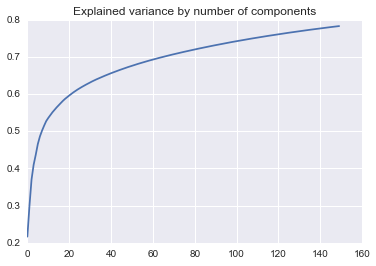

In [6]:
f = plt.plot(svd.explained_variance_ratio_.cumsum())  # these are the singular values 
f = plt.title("Explained variance by number of components")

Great, we can describe almost 80% of our variance by just 150 dimensions, and even better, 50% of our varaince by only a handful of components.

Each component is made out of a certain word combination with different weights. Let's have a look at themost important components.

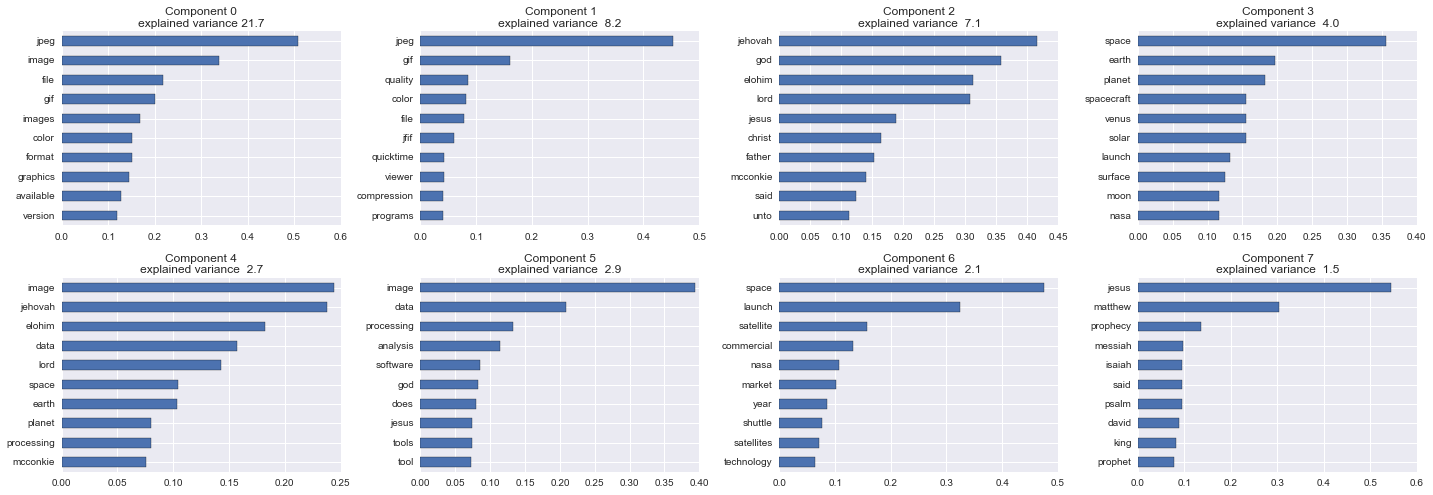

In [7]:
words = np.array(vectorizer.get_feature_names())
top_words = 10
n_rows, n_cols = 2, 4
top_components = n_rows * n_cols
f, axes = plt.subplots(2, 4, figsize=(20, 7))
for no, component in enumerate(svd.components_[:top_components]):
    ax = axes[no / n_cols][no % n_cols]
    s = pd.Series(svd.components_[no], index=words).sort(inplace=False)[-top_words:]
    s.plot(kind='barh', ax=ax, title="Component %d\nexplained variance %4.1f" % 
           (no, 100 * svd.explained_variance_ratio_[no]))
f = plt.tight_layout()

Very clear results! 

Let's look at our documents and see how an article is represented in these dimensions.

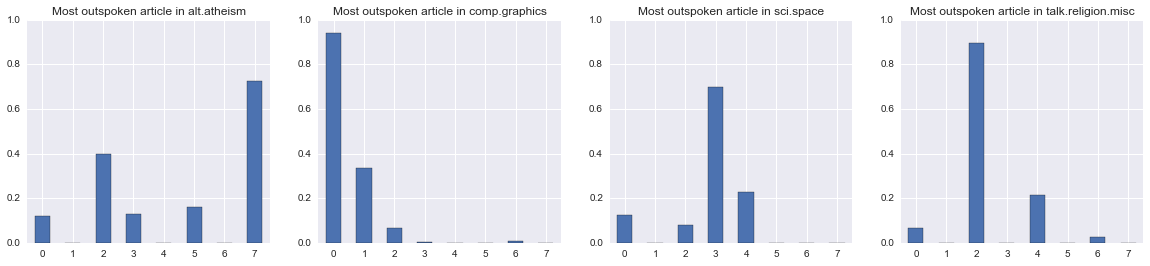

In [8]:
f, axes = plt.subplots(1, true_k, figsize=(20, 4))
for label in xrange(true_k):
    X_red_class = X_red[labels == label]
    no = np.abs(X_red_class[:, :top_components]).max(axis=1).argmax()  # pick most outspoken sample
    f = pd.Series(X_red_class[no][:top_components]).plot(
        title="Most outspoken article in %s" % dataset.target_names[label],
        kind='bar', rot=0, ylim=(0, 1), ax=axes[label])

Indeed, the article has stronger representation in the component that resembles its category.

This is just data magic!